# Face Recognition using Siamese Neural Networks
Utilizing Convolutional Neural Networks (CNNs) for Face Recognition via One-shot Classification.


This notebook applies the principles outlined in the paper ["Siamese Neural Networks for One-shot Image Recognition"](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) authored by Gregory Koch, Richard Zemel, and Ruslan Salakhutdinov.

### Imports

In [ ]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
!pip install opencv-python
import cv2
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import datetime
from sklearn.metrics import confusion_matrix

### Initializations

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
data_path = '/content/drive/MyDrive/Face_Recognition_using_Siamese_Neural_Networks/'
lfw2_path = '/content/drive/MyDrive/Face_Recognition_using_Siamese_Neural_Networks/lfw2/lfw2/'
train_path = '/content/drive/MyDrive/Face_Recognition_using_Siamese_Neural_Networks/pairsDevTrain.txt'
test_path = '/content/drive/MyDrive/Face_Recognition_using_Siamese_Neural_Networks/pairsDevTest.txt'

### Unzip the Data

In [ ]:
drive.mount('/content/drive')  # Give an access to Google Drive contents
if not os.path.exists(lfw2_path):
  os.chdir(data_path)  # navigate to the requested folder
  !unzip lfwa.zip  # Extract the images
  print("Extraction of lfw2 complete!")
else:
  print("Folder lfw2 already exists. Skipping extraction.")

Streaming output truncated to the last 5000 lines.
   creating: lfw2/lfw2/Pamela_Anderson/
 extracting: lfw2/lfw2/Pamela_Anderson/Pamela_Anderson_0001.jpg  
  inflating: lfw2/lfw2/Pamela_Anderson/Pamela_Anderson_0002.jpg  
 extracting: lfw2/lfw2/Pamela_Anderson/Pamela_Anderson_0003.jpg  
  inflating: lfw2/lfw2/Pamela_Anderson/Pamela_Anderson_0004.jpg  
 extracting: lfw2/lfw2/Pamela_Anderson/Pamela_Anderson_0005.jpg  
   creating: lfw2/lfw2/Pamela_Melroy/
 extracting: lfw2/lfw2/Pamela_Melroy/Pamela_Melroy_0001.jpg  
   creating: lfw2/lfw2/Paola_Espinoza/
  inflating: lfw2/lfw2/Paola_Espinoza/Paola_Espinoza_0001.jpg  
   creating: lfw2/lfw2/Paradorn_Srichaphan/
 extracting: lfw2/lfw2/Paradorn_Srichaphan/Paradorn_Srichaphan_0001.jpg  
 extracting: lfw2/lfw2/Paradorn_Srichaphan/Paradorn_Srichaphan_0002.jpg  
 extracting: lfw2/lfw2/Paradorn_Srichaphan/Paradorn_Srichaphan_0003.jpg  
  inflating: lfw2/lfw2/Paradorn_Srichaphan/Paradorn_Srichaphan_0004.jpg  
  inflating: lfw2/lfw2/Paradorn_Sric

## Section 2 - Loading and Preprocessing of the Labeled Faces in the Wild-a (LFW-a) Dataset

In [ ]:
def read_txt_file_and_determine_size(file_path):
  """
  Reads a .txt file and counts the amount of identical and different samples in it.
  The training and test sets are divided into:
  1. Images associated with the same individual (the first 1100 records in the training and the first 500 in the test)
  2. A pair of images of two different individuals (the remaining 1,100 records in the training and the remaining 500 in the test)

  Parameters:
    file_path (str): The path of the .txt file to be read.

  Returns:
    samples (list): A list containing all the samples in the data.
    num_of_identical (int): Counts the amount of images associated with the same individual.
    num_of_different (int): Counts the amount of pair of images of two different individuals.
  """
  with open(file_path, 'r') as data:
    data_lines = data.readlines()
    samples = data_lines[1:]
    num_of_identical = int(data_lines[0])  # The first row is the metadata, indicates the number of lines of images associated with the same individual
    num_of_different = len(samples) - num_of_identical
    return samples, num_of_identical, num_of_different

In [ ]:
def load_lfw2_dataset():
  """
  Loads and preprocesses the lfw2 dataset.

  Returns:
    train_pairs_df (pd.DataFrame): Training DataFrame (including identical and different individuals).
    test_pairs_df (pd.DataFrame): Test DataFrame (including identical and different individuals).
  """
  # Creates labels array of 1's for the identical images (associated with the same individual)
  # Creates labels array of 0's for different images (A pair of images of two different individuals)
  X_training_data, num_of_train_identical, num_of_train_different = read_txt_file_and_determine_size(train_path)
  X_test_data, num_of_test_identical, num_of_test_different = read_txt_file_and_determine_size(test_path)

  # Create image paths pairs from each record in the dataset
  X_train_identical_pairs = create_images_path(X_training_data[:num_of_train_identical], True)
  X_train_different_pairs = create_images_path(X_training_data[num_of_train_identical:], False)
  X_test_identical_pairs = create_images_path(X_test_data[:num_of_test_identical], True)
  X_test_different_pairs = create_images_path(X_test_data[num_of_test_identical:], False)

  # Create a dataframe for the training set (including identical and different individuals)
  identical_pairs_df = convert_pairs_path_to_df(X_train_identical_pairs, True)
  different_pairs_df = convert_pairs_path_to_df(X_train_different_pairs, False)
  train_pairs_df = pd.concat([identical_pairs_df, different_pairs_df], ignore_index=True)

  # Create a dataframe for the test set (including identical and different individuals)
  identical_pairs_df = convert_pairs_path_to_df(X_test_identical_pairs, True)
  different_pairs_df = convert_pairs_path_to_df(X_test_different_pairs, False)
  test_pairs_df = pd.concat([identical_pairs_df, different_pairs_df], ignore_index=True)

  return train_pairs_df, test_pairs_df

In [ ]:
def convert_pairs_path_to_df(data, is_identical):
  """
  Creates a Data Frame of image pairs using the pairs path with the columns: 'Image1', 'Image2', 'Label'.

  Parameters:
    data (list): Training DataFrame (including identical and different individuals).
    is_identical (bool): A boolean flag used to determine whether a pair of images is of the same individual.

  Returns:
    pairs_df (pd.DataFrame): A Data Frame where each record is a pair of images and their label.
  """
  pairs_dict = {'Image1': [], 'Image2': [], 'Label': []}
  if is_identical:
    for pair in data:
      img1 = cv2.imread(pair[0], cv2.IMREAD_GRAYSCALE)  # Return a numpy array representing the image with the shape (num_rows, num_cols, num_channels)
      img1 = img1.astype('float32') / 255.0  # Convert each image to float and normalize by maximum value
      img2 = cv2.imread(pair[1], cv2.IMREAD_GRAYSCALE)
      img2 = img2.astype('float32') / 255.0

      # Experiment 1: The comments here are part of an experiment that was finally decided to be abandoned.
      # An attempt was made to resize the images, but adding more layers to the model yields better performance
      # img1 = cv2.resize(img1, (105, 105), interpolation=cv2.INTER_AREA)
      # img1 = np.expand_dims(img1, axis=0)
      # img2 = cv2.resize(img2, (105, 105), interpolation=cv2.INTER_AREA)
      # img2 = np.expand_dims(img2, axis=0)

      pairs_dict['Image1'].append(img1)
      pairs_dict['Image2'].append(img2)
      pairs_dict['Label'].append(1)
  else:
    for pair in data:
      img1 = cv2.imread(pair[0], cv2.IMREAD_GRAYSCALE)
      img1 = img1.astype('float32') / 255.0
      img2 = cv2.imread(pair[1], cv2.IMREAD_GRAYSCALE)
      img2 = img2.astype('float32') / 255.0

      # img1 = cv2.resize(img1, (105, 105), interpolation=cv2.INTER_AREA)  # Resize and add channel dimension
      # img1 = np.expand_dims(img1, axis=0)  # Add channel dimension
      # img2 = cv2.resize(img2, (105, 105), interpolation=cv2.INTER_AREA)
      # img2 = np.expand_dims(img2, axis=0)

      pairs_dict['Image1'].append(img1)
      pairs_dict['Image2'].append(img2)
      pairs_dict['Label'].append(0)
  return pd.DataFrame(pairs_dict)

In [ ]:
def create_images_path(rows, is_identical):
  """
  Creates image path pairs from a list containing samples from the loaded data.

  Parameters:
    rows (list): A list containing samples from the loaded data.
    is_identical (bool): A boolean flag used to determine whether a pair of images is of the same individual.

  Returns:
    image_pairs_path (list): A list of image path pairs.
  """
  image_pairs_path = []
  for i in range(len(rows)):
      row_components = rows[i].split()
      folder_name = lfw2_path + row_components[0] + '/'
      image_name = f"{row_components[0]}_{int(row_components[1]):04d}.jpg"  # Pad the image number with leading zeros
      image1_path = folder_name + image_name

      if is_identical:
        image_name = f"{row_components[0]}_{int(row_components[2]):04d}.jpg"
        image2_path = folder_name + image_name
      else:
        folder_name = lfw2_path + row_components[2] + '/'
        image_name = f"{row_components[2]}_{int(row_components[3]):04d}.jpg"
        image2_path = folder_name + image_name
      image_pairs_path.append(np.array([image1_path, image2_path]))
  return image_pairs_path

In [ ]:
class SiameseDataset(Dataset):
  """
  Converts the dataframe to a Dataset consisting of tensors.
  """
  def __init__(self, dataframe, transform=None):
    tensor_images = []
    for col in dataframe.columns[:-1]:
      tensor_images.append(torch.tensor(dataframe[col].tolist(), dtype=torch.float))
    self.x = torch.stack(tensor_images, dim=1)  # When dim=1 the tensors are transposed and stacked along the column
    self.labels = torch.tensor(dataframe.iloc[:, -1].tolist(), dtype=torch.float)
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    image = self.x[idx]
    label = self.labels[idx]
    if self.transform:  # Perform augmentation
        augmented_image = self.transform(image)
        return augmented_image, label
    else:
        return image, label

In [ ]:
train_pairs_df, test_pairs_df = load_lfw2_dataset()

In [ ]:
print(f"The train set consist {train_pairs_df.shape[0]} samples, where {train_pairs_df.isnull().any(axis=1).sum()} of them are corrupted")

The train set consist 2200 samples, where 0 of them are corrupted


In [ ]:
print(f"The test set consist {test_pairs_df.shape[0]} samples, where {test_pairs_df.isnull().any(axis=1).sum()} of them are corrupted")

The test set consist 1000 samples, where 0 of them are corrupted


## Section 3 - Siamese Network

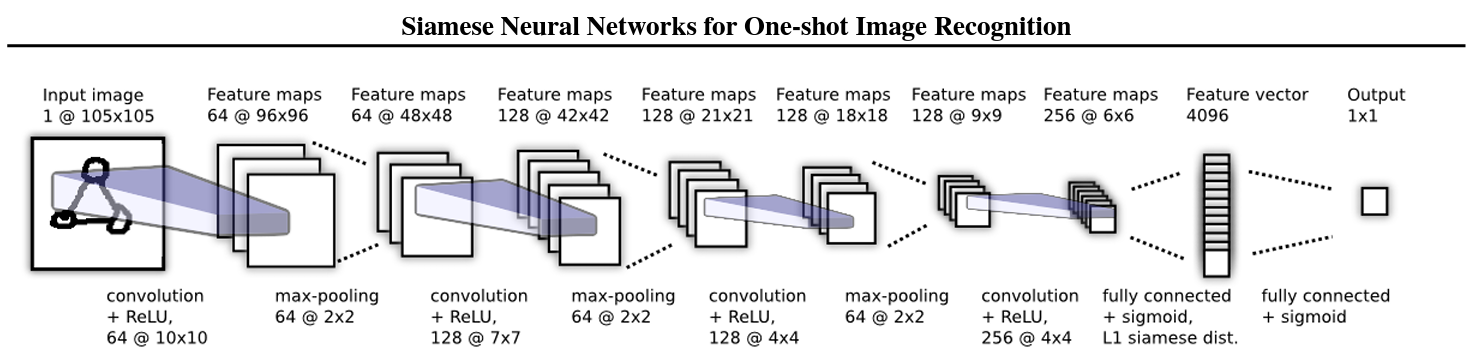

In [ ]:
class SiameseNetwork(nn.Module):
  """
  Creates a SiameseNetwork based on the architecture in the paper, enhanced with additional layers.
  """
  def __init__(self):
    super(SiameseNetwork, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(10, 10), stride=1, padding=0),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        # The following lines are the additional layers
        nn.MaxPool2d(2),
        nn.Conv2d(256, 256, kernel_size=7),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Sequential(
        nn.Linear(256 * 3 * 3, 4096),
        nn.Sigmoid()
    )
    self.fc2 = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
    )
    # self.apply(self.initialize_parameters)

  # Experiment 2: The comments here are part of an experiment that was finally decided to be abandoned.
  # An attempt was made to initialize parameters for the layers, but removing the initialization resulted in better model performance
  # def initialize_parameters(self, layer):
  #   if isinstance(layer, (nn.Conv2d, nn.Linear)):
  #       # Initialize weights using a normal distribution
  #       nn.init.normal_(layer.weight, mean=0.0, std=0.01 if isinstance(layer, nn.Conv2d) else 0.2)
  #       # Initialize biases using a normal distribution with mean 0.5
  #       nn.init.normal_(layer.bias, mean=0.5, std=0.01)

  def forward_once(self, x):
    x = self.conv(x)  # The output after the convolution layers
    x = x.view(x.size()[0], -1)  # Flatten the output from the convolutional layers into a 1D tensor
    feature_vector = self.fc1(x)  # The output after the fully connected layer
    return feature_vector

  def forward(self, x1, x2):
    y1 = self.forward_once(x1)  # First image feature vector
    y2 = self.forward_once(x2)  # Second image feature vector
    L1_dist = torch.abs(y1 - y2)  # Vector of size 4096
    L1_weighted_dist = self.fc2(L1_dist)
    return L1_weighted_dist.squeeze()

### Run the Network - Training the Model and Making Predictions

In [ ]:
def accuracy_tracking_and_printing(best_model, train_loader, validation_loader, loss_fn, epoch):
  """
  Calculates and prints the accuracy of the training set and validation set with the amount of epochs performed.

  Parameters:
    best_model (SiameseNetwork): A SiameseNetwork with the parameters that yield the lowest validation loss.
    train_loader (DataLoader): A DataLoader of the training set.
    validation_loader (DataLoader): A DataLoader of the validation set.
    loss_fn (torch.nn): A criterion that measures the loss between the probabilities and the true labels.
    epoch (int): Number of epochs.
  """
  print(f"\nNumber of epochs: {epoch}")
  print(f"Training Set Accuracy: {round(predict(best_model, train_loader, loss_fn)[0], 3)}")
  print(f"Validation Set Accuracy: {round(predict(best_model, validation_loader, loss_fn)[0], 3)}\n")

In [ ]:
def train(model, train_loader, validation_loader, loss_fn, optimizer, learning_rate):
  """
  Trains the SiameseNetwork using the train_loader and calculates training loss and validation loss.

  Parameters:
    model (SiameseNetwork): A SiameseNetwork.
    train_loader (DataLoader): A DataLoader of the training set.
    validation_loader (DataLoader): A DataLoader of the validation set.
    loss_fn (torch.nn): A criterion that measures the loss between the probabilities and the true labels.
    optimizer (torch.optim): An Optimizer.
    learning_rate (float): A learning rate.

  Returns:
    loss_dict (dict): A dictionary containing the training loss and the validation loss of each epoch.
    best_model (SiameseNetwork): A SiameseNetwork with the parameters that yield the lowest validation loss.
  """
  size = len(train_loader.dataset)
  train_num_batches = len(train_loader)
  val_num_batches = len(validation_loader)
  model.train()  # Put the model into training mode
  best_val_loss = np.inf
  init_momentum = 0.5  # The initial value of the momentum according to the paper
  epochs = 100
  loss_dict = {'Epoch': [], 'Training Loss': [], 'Validation Loss': []}
  count_no_improve = 0  # Count the number of consecutive times that the validation loss does not improve
  start_time = datetime.datetime.now()

  # Training the network
  for epoch in tqdm(range(epochs)):
    total_train_loss, total_val_loss = 0, 0
    curr_momentum = init_momentum + (1 - init_momentum) * (epoch / epochs)  # Momentum starts at 0.5 in every layer and increases linearly in each epoch according to the paper

    model.train()  # Put the model into training mode before iterating over the training data
    for batch, (X_train_batch, Y_train_batch) in enumerate(train_loader):
      X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device).to(torch.float)
      image1_train_batch = X_train_batch[:, 0].unsqueeze(1)  # Extract all the first images ("Image1" column) of the batch
      image2_train_batch = X_train_batch[:, 1].unsqueeze(1)  # Extract all the second images ("Image2" column) of the batch

      # Compute training prediction loss
      train_predictions = model(image1_train_batch, image2_train_batch).squeeze()
      loss = loss_fn(train_predictions, Y_train_batch)
      total_train_loss += loss.item()

      # Backpropagation process
      optimizer.zero_grad()
      loss.backward()
      optimizer.param_groups[0]['betas'] = (curr_momentum, 0.8)  # Update momentum
      optimizer.param_groups[0]['lr'] = learning_rate  # Update learning rate
      optimizer.step()
    avg_train_loss = total_train_loss / train_num_batches  # The average training loss per epoch
    learning_rate *= 0.99  # Learning rates are decayed uniformly across the network by 1 percent per epoch according to the paper

    # Calculate cost value on validation after each training epoch
    model.eval()  # Put the model into evaluation mode
    with torch.no_grad():  # Operations inside this block will not be tracked for gradient computation
      for batch, (X_val_batch, Y_val_batch) in enumerate(validation_loader):
        X_val_batch, Y_val_batch = X_val_batch.to(device), Y_val_batch.to(device).to(torch.float)
        image1_val_batch = X_val_batch[:, 0].unsqueeze(1)
        image2_val_batch = X_val_batch[:, 1].unsqueeze(1)

        # Compute validation prediction loss
        val_predictions = model(image1_val_batch, image2_val_batch).squeeze()
        total_val_loss += loss_fn(val_predictions, Y_val_batch).item()

    curr_avg_val_loss = total_val_loss / val_num_batches  # The average validation loss per epoch
    loss_dict['Epoch'].append(epoch + 1)
    loss_dict['Training Loss'].append(avg_train_loss)
    loss_dict['Validation Loss'].append(curr_avg_val_loss)

    # Stop condition
    if curr_avg_val_loss < best_val_loss:
      best_val_loss = curr_avg_val_loss

      best_params = torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': curr_avg_val_loss},
        'Adam_with_lr=0.001.pth')

      count_no_improve = 0
    else:
      count_no_improve += 1
      if count_no_improve == 10:
        best_model = SiameseNetwork().to(device)
        best_params = torch.load('Adam_with_lr=0.001.pth')
        best_model.load_state_dict(best_params['model_state_dict'])
        accuracy_tracking_and_printing(best_model, train_loader, validation_loader, loss_fn, epoch + 1)
        print(f"Training terminated early due to convergence criteria met at epoch {epoch + 1}")
        return loss_dict, best_model

  best_model = SiameseNetwork().to(device)
  best_params = torch.load('Adam_with_lr=0.001.pth')
  best_model.load_state_dict(best_params['model_state_dict'])
  accuracy_tracking_and_printing(best_model, train_loader, validation_loader, loss_fn, epoch + 1)
  print("Training completed all epochs without meeting convergence criteria")
  return loss_dict, best_model

In [ ]:
def predict(model, test_loader, loss_fn):
  """
  Predicts the probabilities using the trained SiameseNetwork and the test_loader, and calculates accuracy score.

  Parameters:
    model (SiameseNetwork): A SiameseNetwork with the parameters that yield the lowest validation loss.
    test_loader (DataLoader): A DataLoader of the test set.
    loss_fn (torch.nn): A criterion that measures the loss between the probabilities and the true labels.

  Returns:
    accuracy (float): The accuracy score of the model.
    test_predictions_list (list): A list containing the model predictions.
    Y_test_list (list): A list containing the true labels of the data.
  """
  test_predictions_list = []
  Y_test_list = []
  correct_predictions, total_test_loss = 0, 0
  size = len(test_loader.dataset)
  num_batches = len(test_loader)

  model.eval()  # Put the model into evaluation mode
  with torch.no_grad():  # Operations inside this block will not be tracked for gradient computation
    for batch, (X_test_batch, Y_test_batch) in enumerate(test_loader):
      X_test_batch, Y_test_batch = X_test_batch.to(device), Y_test_batch.to(device).to(torch.float)
      image1_test_batch = X_test_batch[:, 0].unsqueeze(1)
      image2_test_batch = X_test_batch[:, 1].unsqueeze(1)

      # Compute test prediction loss
      test_probabilities = model(image1_test_batch, image2_test_batch).squeeze()
      total_test_loss += loss_fn(test_probabilities, Y_test_batch).item()

      # Contains the binary predictions. Classification to 1 where pred_proba >= 0.5 and 0 where pred_proba < 0.5
      test_predictions = (test_probabilities >= 0.5).float()  # Assuming binary classification, setting the threshold value to 0.5
      correct_predictions += (test_predictions == Y_test_batch).sum().item()
      test_predictions_list.extend(test_predictions.cpu().numpy())
      Y_test_list.extend(Y_test_batch.cpu().numpy())

  accuracy = correct_predictions / size
  curr_avg_test_loss = total_test_loss / num_batches
  return accuracy, test_predictions_list, Y_test_list

In [ ]:
def export_dict_to_csv(loss_dict, csv_name):
  """
  Exports a dictionary to a CSV file, with keys as column names and values as their respective entries.

  Parameters:
    loss_dict (dict): A dictionary where each key is a string and each value is a list.
    csv_name (str): The specified name for the CSV file.
  """
  loss_df = pd.DataFrame(loss_dict)
  loss_df.to_csv(csv_name, index=False)

### Experimental Setup

In [ ]:
batch_size = 16

# Original training set
original_train_dataset = SiameseDataset(train_pairs_df)

# Augmented training set
augmented_train_dataset = SiameseDataset(train_pairs_df, transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),    # Random horizontal flip
    transforms.RandomVerticalFlip(),      # Random vertical flip
    transforms.RandomRotation(degrees=30),  # Random rotation within ±30 degrees
]))

combined_train_lfw2_dataset = ConcatDataset([original_train_dataset, augmented_train_dataset])
print("combined_train_lfw2_dataset:", len(combined_train_lfw2_dataset))

val_size = int(0.1 * len(combined_train_lfw2_dataset))  # Calculate the number of samples for the validation set
indices = list(range(len(combined_train_lfw2_dataset)))  # Define the indices for the train and validation sets

# Set the random seed for reproducibility
random_state = 42
np.random.seed(random_state)
np.random.shuffle(indices)

train_indices = indices[val_size:]
val_indices = indices[:val_size]
train_dataset = Subset(combined_train_lfw2_dataset, train_indices)  # Create Subset datasets using the indices
print("train_dataset:", len(train_dataset))
train_lfw2_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation set
val_lfw2_dataset = Subset(combined_train_lfw2_dataset, val_indices)
print("val_lfw2_dataset:", len(val_lfw2_dataset))
val_lfw2_dataloader = DataLoader(val_lfw2_dataset, batch_size=batch_size, shuffle=True)

# Test set
test_lfw2_dataset = SiameseDataset(test_pairs_df)
print("test_lfw2_dataset:", len(test_lfw2_dataset))
test_lfw2_dataloader = DataLoader(test_lfw2_dataset, batch_size=batch_size, shuffle=True)

<ipython-input-9-12082f387693>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  tensor_images.append(torch.tensor(dataframe[col].tolist(), dtype=torch.float))


combined_train_lfw2_dataset: 4400
train_dataset: 3960
val_lfw2_dataset: 440
test_lfw2_dataset: 1000


In [ ]:
# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
lfw2_siamese_network = SiameseNetwork().to(device)
print(lfw2_siamese_network)

SiameseNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, strid

In [ ]:
loss_fn = nn.BCELoss()
batch_size = 16
learning_rate = 0.0001
weight_decay = 0.1
optimizer = optim.AdamW(lfw2_siamese_network.parameters(), lr=learning_rate, weight_decay=weight_decay , betas=(0.5, 0.8))

In [ ]:
# Grid search and experimenting with several different hyperparameter combinations
loss_fn = nn.BCELoss()
batch_sizes = [16, 32]
init_learning_rates = [0.001, 0.0001]
weight_decays = [0.1, 0.01]

for batch_size in batch_sizes:
  for init_LR in init_learning_rates:
    for weight_decay in weight_decays:
      optimizer = optim.AdamW(lfw2_siamese_network.parameters(), lr=init_learning_rates, weight_decay=weight_decay , betas=(0.5, 0.8))
      # Training set
      train_lfw2_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      # Validation set
      val_lfw2_dataset = Subset(combined_train_lfw2_dataset, val_indices)
      val_lfw2_dataloader = DataLoader(val_lfw2_dataset, batch_size=batch_size, shuffle=True)
      # Test set
      test_lfw2_dataset = SiameseDataset(test_pairs_df)
      test_lfw2_dataloader = DataLoader(test_lfw2_dataset, batch_size=batch_size, shuffle=True)
      start_time = datetime.datetime.now()
      loss_dict, best_siamese_network = train(lfw2_siamese_network, train_lfw2_dataloader, val_lfw2_dataloader, loss_fn, optimizer, init_LR)
      print(f"Training Time for batch_size = {batch_size}, batchnorm = True, init_LR = {init_LR}, weight_decay = {weight_decay} is: {datetime.datetime.now() - start_time}")
      accuracy_test, test_predictions_list, Y_test_list = predict(best_siamese_network, test_lfw2_dataloader, loss_fn)
      accuracy_test = round(accuracy_test, 3)
      print(f"\nTest Set Accuracy for batch_size = {batch_size}, batchnorm = True, init_LR = {init_LR}, weight_decay = {weight_decay} is: {accuracy_test}\n---------------------------------------------")
      export_dict_to_csv(loss_dict, f"/content/Loss_with_BatchSize_{batch_size}_BatchNorm_True_LR_{init_LR}_WeightDecay_{weight_decay}.csv")

In [ ]:
start_time = datetime.datetime.now()
loss_dict, best_siamese_network = train(lfw2_siamese_network, train_lfw2_dataloader, val_lfw2_dataloader, loss_fn, optimizer, learning_rate)
print(f"Training Time for batch_size = {batch_size}, batchnorm = True, init_LR = {learning_rate}, weight_decay = {weight_decay} is: {datetime.datetime.now() - start_time}")
accuracy_test, test_predictions_list, Y_test_list = predict(best_siamese_network, test_lfw2_dataloader, loss_fn)
accuracy_test = round(accuracy_test, 3)
print(f"\nTest Set Accuracy for batch_size = {batch_size}, batchnorm = True, init_LR = {learning_rate}, weight_decay = {weight_decay} is: {accuracy_test}\n---------------------------------------------")
export_dict_to_csv(loss_dict, f"/content/Loss_with_BatchSize_{batch_size}_BatchNorm_True_LR_{learning_rate}_WeightDecay_{weight_decay}.csv")

 39%|███▉      | 39/100 [45:31<1:10:49, 69.66s/it]


Number of epochs: 40
Training Set Accuracy: 0.979


 39%|███▉      | 39/100 [47:09<1:13:44, 72.54s/it]

Validation Set Accuracy: 0.859

Training terminated early due to convergence criteria met at epoch 40
Training Time for batch_size = 16, batchnorm = True, init_LR = 0.0001, weight_decay = 0.1 is: 0:47:09.079711



Test Set Accuracy for batch_size = 16, batchnorm = True, init_LR = 0.0001, weight_decay = 0.1 is: 0.754
---------------------------------------------


## Section 4 - Analysis of the Architecture's Performance

In [ ]:
def confusion_matrix_results(preds, labels):
  """
  Creates a confusion matrix based on the predictions and the true labels, and calculates the True-Positive (TP), True-Negative (TN), False-Positive (FP) and False-Negative (FN).

  Parameters:
    preds (list): A list containing the model predictions.
    labels (list): A list containing the true labels of the data.

  Returns:
    TP, TN, FP, FN (ints): True-Positive, True-Negative, False-Positive and False-Negative values.
  """
  TP, TN, FP, FN = 0, 0, 0, 0
  for pred, label in zip(preds, labels):
      if pred == 1 and label == 1:
        TP += 1
      elif pred == 0 and label == 0:
        TN += 1
      elif pred == 1 and label == 0:
        FP += 1
      elif pred == 0 and label == 1:
        FN += 1
  return TP, TN, FP, FN

In [ ]:
TP, TN, FP, FN = confusion_matrix_results(test_predictions_list, Y_test_list)
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)

True Positives: 395
True Negatives: 359
False Positives: 141
False Negatives: 105


In [ ]:
def plot_confusion_matrix(TP, TN, FP, FN):
  """
  Plots a confusion matrix.

  Parameters:
    TP (int): True-Positive value.
    TN (int): True-Negative value.
    FP (int): False-Positive value.
    FN (int): False-Negative value.
  """
  confusion_mat = np.array([[TP, FP], [FN, TN]])
  sns.set(font_scale=1.2)
  plt.figure(figsize=(6, 4))
  sns.heatmap(confusion_mat, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted Positive', 'Predicted Negative'],
              yticklabels=['Actual Positive', 'Actual Negative'])
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion Matrix')
  plt.show()

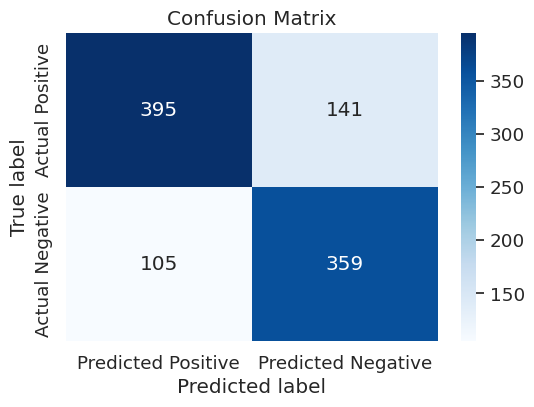

In [ ]:
plot_confusion_matrix(TP, TN, FP, FN)

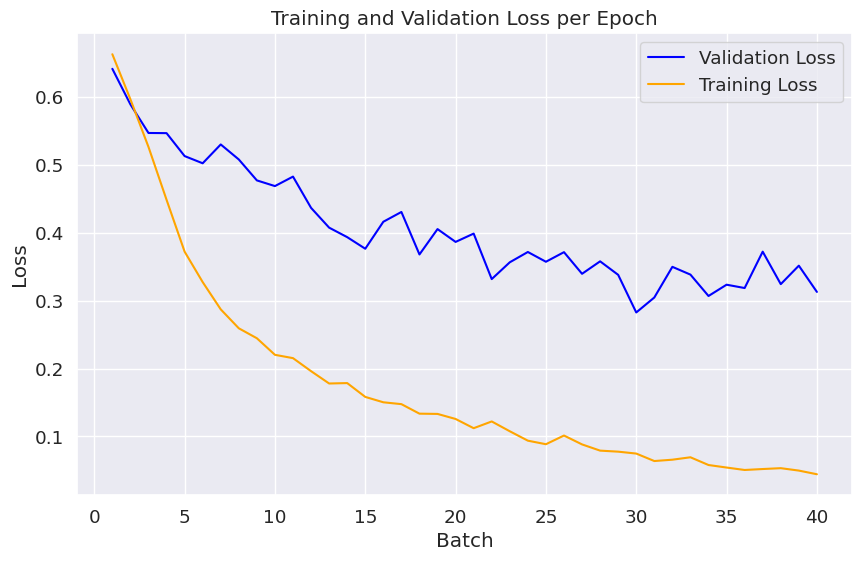

In [ ]:
def plot_test_loss_per_epoch(loss_dict):
  """
  Plot the training and validation loss per epoch.

  Parameters:
    TP (int): True-Positive value.
  """
  num_batches = len(loss_dict['Epoch'])
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, num_batches + 1), loss_dict['Validation Loss'], color='blue', label='Validation Loss')
  plt.plot(range(1, num_batches + 1), loss_dict['Training Loss'], color='orange', label='Training Loss')
  plt.xlabel('Batch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss per Epoch')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_test_loss_per_epoch(loss_dict)